In [4]:
import os
import numpy as np
import pandas as pd
import datetime
from sklearn.preprocessing import normalize
from scipy.stats import anderson_ksamp
from scipy.stats import ks_2samp
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
% matplotlib inline

In [16]:
# data directory
data_dir = '/gws/projects/project-uo_rebound/workspace/share/output_dc/final'

In [19]:
# load lightcurves
curves_hsi = np.load(os.path.join(data_dir,'curves_hsi.npy'))  # all mask (hsi)
curves_class = np.load(os.path.join(data_dir,'curves_class.npy'))  # all w spectra
curves_led = np.load(os.path.join(data_dir,'curves_led.npy')) # led
curves_hps = np.load(os.path.join(data_dir,'curves_hps.npy')) # high pressure sodium
curves_lps = np.load(os.path.join(data_dir,'curves_lps.npy')) # low pressure sodium
curves_mh = np.load(os.path.join(data_dir,'curves_mh.npy')) # metal halide
curves_f = np.load(os.path.join(data_dir,'curves_f.npy')) # fluorescent
curves_q = np.load(os.path.join(data_dir,'curves_q.npy')) # quartz halogen
curves_gow = np.load(os.path.join(data_dir,'curves_gow.npy')) # gowanus

In [20]:
# load ons
ons_hsi = np.load(os.path.join(data_dir,'ons_hsi.npy')) # all mask (hsi)
ons_class = np.load(os.path.join(data_dir,'ons_class.npy')) # all w spectra
ons_led = np.load(os.path.join(data_dir,'ons_led.npy')) # led
ons_hps = np.load(os.path.join(data_dir,'ons_hps.npy')) # high pressure sodium
ons_lps = np.load(os.path.join(data_dir,'ons_lps.npy')) # low pressure sodium
ons_mh = np.load(os.path.join(data_dir,'ons_mh.npy')) # metal halide
ons_f = np.load(os.path.join(data_dir,'ons_f.npy')) # fluorescent
ons_q = np.load(os.path.join(data_dir,'ons_q.npy')) # quartz halogen
ons_gow = np.load(os.path.join(data_dir,'ons_gow.npy')) # gowanus

In [21]:
# load offs
offs_hsi = np.load(os.path.join(data_dir,'offs_hsi.npy')) # all mask (hsi)
offs_class = np.load(os.path.join(data_dir,'offs_class.npy')) # all w spectra
offs_led = np.load(os.path.join(data_dir,'offs_led.npy')) # led
offs_hps = np.load(os.path.join(data_dir,'offs_hps.npy')) # high pressure sodium
offs_lps = np.load(os.path.join(data_dir,'offs_lps.npy')) # low pressure sodium
offs_mh = np.load(os.path.join(data_dir,'offs_mh.npy')) # metal halide
offs_f = np.load(os.path.join(data_dir,'offs_f.npy')) # fluorescent
offs_q = np.load(os.path.join(data_dir,'offs_q.npy')) # quartz halogen
offs_gow = np.load(os.path.join(data_dir,'offs_gow.npy')) # gowanus

In [22]:
# load durations
duration_hsi = np.load(os.path.join(data_dir,'duration_hsi.npy')) # all mask (hsi)
duration_class = np.load(os.path.join(data_dir,'duration_class.npy')) # all w spectra
duration_led = np.load(os.path.join(data_dir,'duration_led.npy')) # led
duration_hps = np.load(os.path.join(data_dir,'duration_hps.npy')) # high pressure sodium
duration_lps = np.load(os.path.join(data_dir,'duration_lps.npy')) # low pressure sodium
duration_mh = np.load(os.path.join(data_dir,'duration_mh.npy')) # metal halide
duration_f = np.load(os.path.join(data_dir,'duration_f.npy')) # fluorescent
duration_q = np.load(os.path.join(data_dir,'duration_q.npy')) # quartz halogen
duration_gow = np.load(os.path.join(data_dir,'duration_gow.npy')) # gowanus

In [23]:
tstamp = np.load(os.path.join(data_dir,'timestamps.npy')).astype('M8[s]').astype('O')

In [24]:
def make_master(n,f):
    n *= 1.0
    f *= -1.0
    m = n + f
    return m

In [25]:
master_hsi = make_master(ons_hsi,offs_hsi)
master_class = make_master(ons_class,offs_class)
master_led = make_master(ons_led,offs_led)
master_hps = make_master(ons_hps,offs_hps)
master_lps = make_master(ons_lps,offs_lps)
master_mh = make_master(ons_mh,offs_mh)
master_f = make_master(ons_f,offs_f)
master_q = make_master(ons_q,offs_q)
master_gow = make_master(ons_gow,offs_gow)

# Plot light sample curves

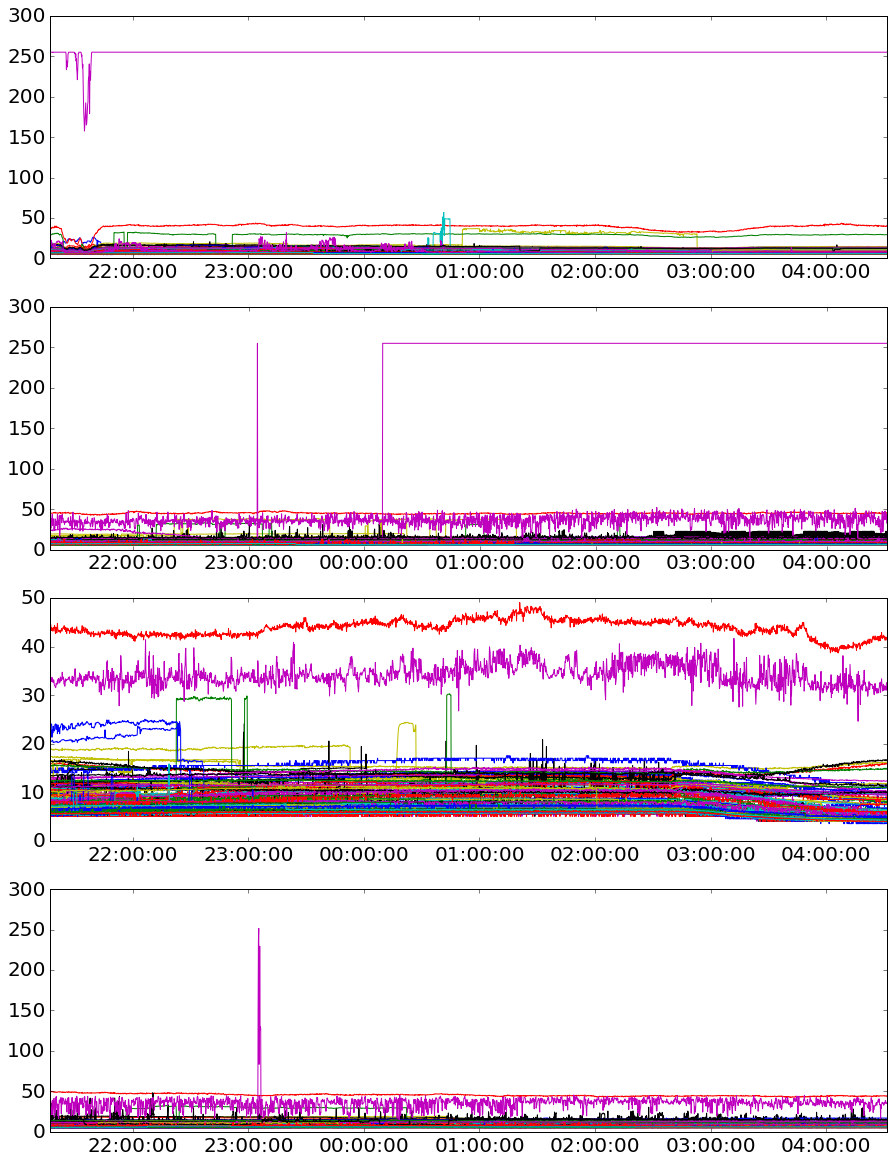

In [54]:
plot_data = curves_gow
fig = plt.figure(figsize=(15,20))

ax1 = fig.add_subplot(411)
ax1 = plt.plot(tstamp[:,12],plot_data[12,:,:])

ax2 = fig.add_subplot(412)
ax2 = plt.plot(tstamp[:,13],plot_data[13,:,:])

ax3 = fig.add_subplot(413)
ax3 = plt.plot(tstamp[:,14],plot_data[14,:,:]);

ax4 = fig.add_subplot(414)
ax4 = plt.plot(tstamp[:,10],plot_data[10,:,:]);

In [27]:
def tags(c,m,night,sort_on,tag):
    
    i,j = np.where(m[sort_on,::-1,:]==tag)
    _, idx = np.unique(j, return_index=True)

    data = c[night]*1.0 / np.amax(c[night],axis=0)

    x_idx,y = np.where(m[night,:,j[np.sort(idx)][::-1]].T == tag)
    
    x = tstamp[x_idx,night]
    
    return data[:,j[np.sort(idx)][::-1]].T, x_idx, y

In [28]:
def plot_curves(c,m,night1,night2,off=True,single=False):
    
    # utils
    first_night = np.datetime64('2017-06-25')
    if off: 
        tag = -1.0
        tag_title = "Off"
    else:
        tag = 1.0
        tag_title = "On"
        
    if single:
        plt.rc('xtick', labelsize=20) 
        plt.rc('ytick', labelsize=20)
        fig,ax = plt.subplots(1,1,figsize=(15, 5))
        pnts, = ax.plot(tags(c,m,night1,night1,tag)[1],tags(c,m,night1,night1,tag)[2],'o',fillstyle='full',
                     mec='orange',color='orange',ms=5,label='{} tags'.format(tag_title))
        ax.imshow(tags(c,m,night1,night1,tag)[0],cmap='gray', interpolation='nearest',vmin=0.3,aspect='auto');
        plt.title("{} tags for {}".format(tag_title, first_night+night1,tag),fontsize=20);
        plt.xlabel('Time of night',fontsize=20)
        plt.ylabel('Sources sorted by "last off"',fontsize=20)
        plt.legend(loc=1,fontsize=20);
#         plt.savefig('lightcurve_hsi_off.jpg',bbox_inches='tight')


    else:
        fig, ax= plt.subplots(3, 1, figsize=(15, 20))
        ax1, ax2, ax3 = ax

        ax1.set_title("{} tags for {}".format(tag_title, first_night+night1))
        pnts, = ax1.plot(tags(c,m,night1,night1)[1],tags(c,m,night1,night1)[2],'o',fillstyle='full',
                         mec='orange',color='orange',ms=2,label='{} tags'.format(tag_title))
        ax1.imshow(tags(c,m,night1,night1)[0],cmap='gray', interpolation='nearest',vmin=0.3,aspect='auto');

        ax2.set_title("{} tags for {}, sorted on {}".format(
                tag_title, first_night+night2, first_night+night2))
        pnts, = ax2.plot(tags(c,m, night2, night2)[1],tags(c,m, night2, night2)[2],'o',fillstyle='full',
                         mec='orange',color='orange',ms=2)
        ax2.imshow(tags(c,m, night2, night2)[0],cmap='gray', interpolation='nearest',vmin=0.3,aspect='auto');

        ax3.set_title("{} tags for {}, sorted on {}".format(
                tag_title, first_night+night2, first_night+night1))
        pnts, = ax3.plot(tags(c, m, night2, night1)[1],tags(c, m, night2, night1)[2],'o',fillstyle='full',
                         mec='orange',color='orange',ms=2)
        ax3.imshow(tags(c, m, night2, night1)[0],cmap='gray', interpolation='nearest',vmin=0.3,aspect='auto');

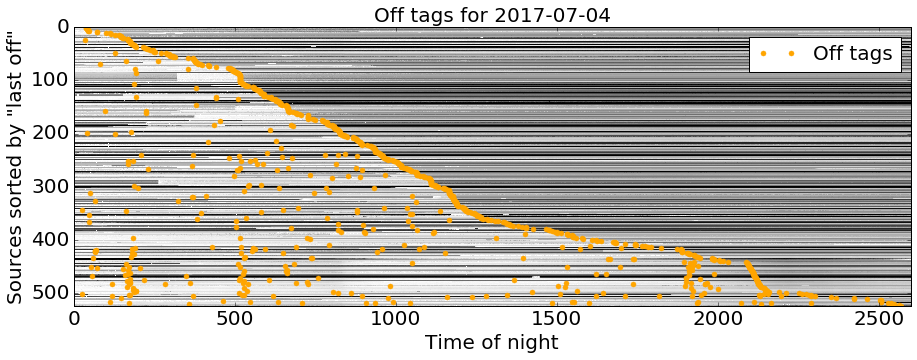

In [30]:
plot_curves(curves_hsi,master_hsi,night1=9,night2=9,off=True,single=True)

#### Duration statistics

In [34]:
def light_stats(data):
    cut = pd.DataFrame(data).T
    cut = cut[cut.sum(axis=1)>0].T.values
    
    print"Total classified: {}".format(data.shape[1])
    print"Total with identified on-duration: {}".format(cut.shape[1])
    print"Total hours: {}".format((cut.sum()/3600).round(2))
    print"Mean hrs all nights: {}".format((cut.sum(axis=0).mean()/3600).round(2))
    print"Mean night in minutes: {}".format((cut.sum(axis=0).mean()/(60*29)).round(2))

In [35]:
print"All class:"
light_stats(duration_class)

All class:
Total classified: 196
Total with identified on-duration: 189
Total hours: 694.45
Mean hrs all nights: 3.67
Mean night in minutes: 7.6


In [36]:
print"LED:"
light_stats(duration_led)

LED:
Total classified: 96
Total with identified on-duration: 91
Total hours: 319.17
Mean hrs all nights: 3.51
Mean night in minutes: 7.26


In [37]:
print"Fluorescent:"
light_stats(duration_f)

Fluorescent:
Total classified: 51
Total with identified on-duration: 50
Total hours: 180.72
Mean hrs all nights: 3.61
Mean night in minutes: 7.48


In [38]:
print"HPS:"
light_stats(duration_hps)

HPS:
Total classified: 22
Total with identified on-duration: 21
Total hours: 87.54
Mean hrs all nights: 4.17
Mean night in minutes: 8.62


In [39]:
print"Metal Halide:"
light_stats(duration_mh)

Metal Halide:
Total classified: 20
Total with identified on-duration: 20
Total hours: 82.92
Mean hrs all nights: 4.15
Mean night in minutes: 8.58


In [40]:
print"LPS:"
light_stats(duration_lps)

LPS:
Total classified: 6
Total with identified on-duration: 6
Total hours: 22.96
Mean hrs all nights: 3.83
Mean night in minutes: 7.92


In [41]:
print"Quartz Halogen:"
light_stats(duration_q)

Quartz Halogen:
Total classified: 1
Total with identified on-duration: 1
Total hours: 1.15
Mean hrs all nights: 1.15
Mean night in minutes: 2.38


In [42]:
print"Gowanus:"
light_stats(duration_gow)

Gowanus:
Total classified: 166
Total with identified on-duration: 165
Total hours: 668.23
Mean hrs all nights: 4.05
Mean night in minutes: 8.38


#### Ons and Offs bar graph

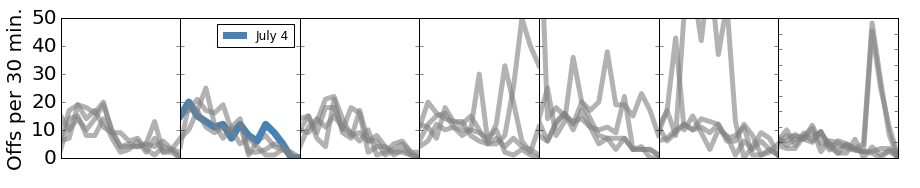

In [28]:
fig = plt.figure(figsize=(15,2.5))
plt.axis('off')

weekday = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
data = offs_gow

nights = 0
p = 1
for nights in [1,2,3,4,5,6,0]:
    plt.ylim([0,50])
    binsize = 180

    plt.subplots_adjust(wspace=0, hspace=0)
    
    ax = fig.add_subplot(1,7,p)
#     plt.title('{}'.format(weekday[nights]))

    for d in np.arange(nights,data.shape[0],7):

        bins = []

        for i in np.arange(0,data.shape[1],binsize):
            bins.append(data[d,i:i+binsize,:].sum())

        xfmt = mdates.DateFormatter('%H')
        ax.xaxis.set_major_formatter(xfmt)

        x_pos = np.arange(0,tstamp.shape[0],binsize)
        if d==9:
            ax.plot(tstamp[x_pos,0],bins,lw=7, c='steelblue',label='July 4');
#             ax.legend(fontsize=40) # big font
            ax.legend()
        else:
            ax.plot(tstamp[x_pos,0],bins,lw=5, c='gray',alpha=.6);
        if p!=1:
            plt.setp(ax.get_yticklabels(), visible=False)
        else:
            ax.set_ylabel('Offs per 30 min.',fontsize=20)
        ax.xaxis.set_visible(False)
        

    p += 1
# plt.savefig('All_offs_gowanus.jpg',bbox_inches='tight')

#### Scale across sources for each night (i.e. independent samples)

In [45]:
# quartz halogen was dropped given it had one light source
all_classes = [duration_led,duration_f, duration_hps, duration_mh, duration_lps]

# filter only to lightcurves with clean on/off transitions (n=189)
all_cut = []
for i in all_classes:
    cut = pd.DataFrame(i).T
    all_cut.append(cut[cut.sum(axis=1)>0].T.values)
    
norm_classes = []
norm_cut = []

In [46]:
# concatenate along axis 1
agg = np.concatenate(all_classes,axis=1)

agg_cut = np.concatenate(all_cut,axis=1)

# 0-centered standardization
agg = abs(agg - agg.mean(axis=1, keepdims=True))
agg /= agg.std(axis=1, keepdims=True)

agg_cut = abs(agg_cut - agg_cut.mean(axis=1, keepdims=True))
agg_cut /= agg_cut.std(axis=1, keepdims=True)

# separate arrays
for i in all_classes:
    norm_classes.append(agg[:,:i.shape[1]])
    
for i in all_cut:
    norm_cut.append(agg_cut[:,:i.shape[1]])

In [47]:
test = np.concatenate(norm_classes[0:2],axis=1)
control = np.concatenate(norm_classes[2:],axis=1)

test_cut = np.concatenate(norm_cut[0:2],axis=1)
control_cut = np.concatenate(norm_cut[2:],axis=1)

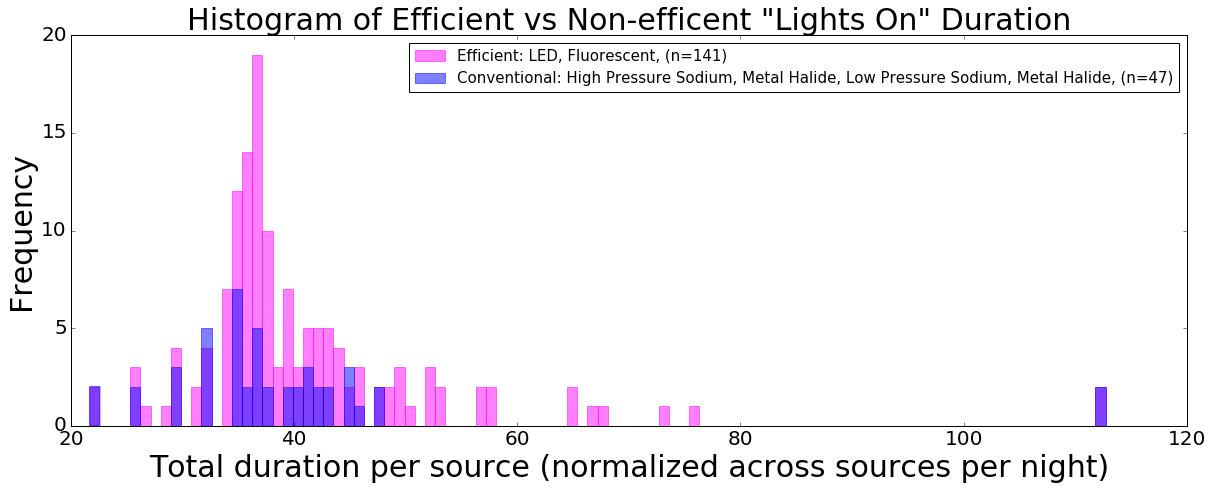

In [49]:
fig,ax = plt.subplots(1,1,figsize=(20,7))
ax.hist(test_cut.sum(axis=0),bins=100, fc='magenta', ec='magenta',alpha=0.5,
        label="Efficient: LED, Fluorescent, (n={})".format(test_cut.shape[1]));
ax.hist(control_cut.sum(axis=0),bins=100, fc='b', ec='b',alpha=0.5,
        label="Conventional: High Pressure Sodium, Metal Halide, Low Pressure Sodium, Metal Halide, (n={})".format(
        control_cut.shape[1]));
ax.legend(fontsize=15);
ax.set_title('Histogram of Efficient vs Non-efficent "Lights On" Duration',fontsize=30)
ax.set_ylabel('Frequency',fontsize=30);
ax.set_xlabel('Total duration per source (normalized across sources per night)',fontsize=30);

# plt.savefig('Stat_hist.jpg',bbox_inches='tight');

## Anderson darling 2 sample test

In [51]:
anderson_ksamp([test_cut.sum(axis=0),control_cut.sum(axis=0)])

Anderson_ksampResult(statistic=0.71642968872445001, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=0.16738542319537772)

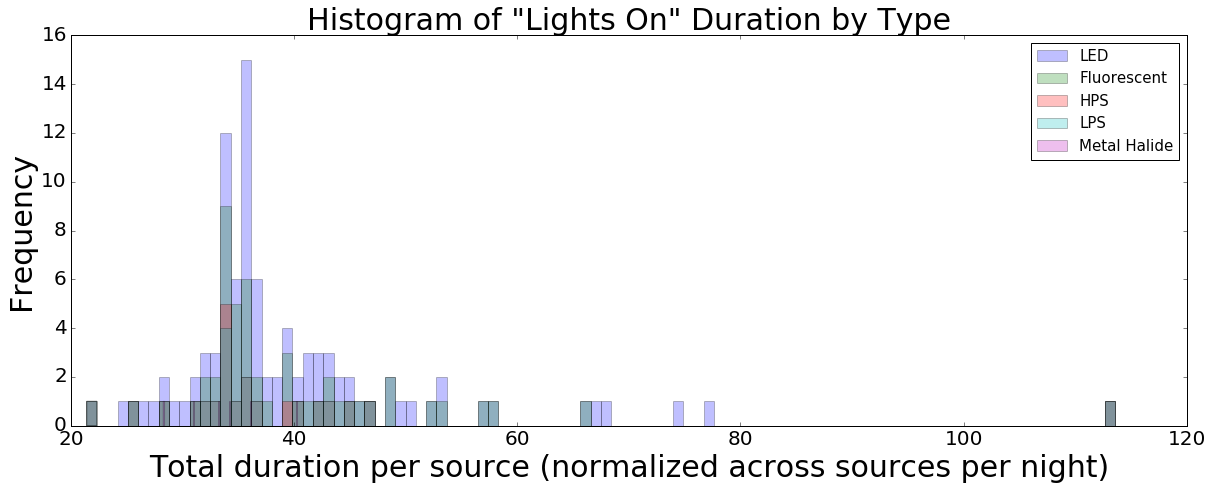

In [53]:
fig,ax = plt.subplots(1,1,figsize=(20,7))
ax.hist(norm_classes[0].sum(axis=0),bins=100, alpha=0.25,
        label="LED");
ax.hist(norm_classes[1].sum(axis=0),bins=100, alpha=0.25,
        label="Fluorescent");
ax.hist(norm_classes[2].sum(axis=0),bins=100, alpha=0.25,
        label="HPS");
ax.hist(norm_classes[3].sum(axis=0),bins=100, alpha=0.25,
        label="LPS");
ax.hist(norm_classes[4].sum(axis=0),bins=100, alpha=0.25,
        label="Metal Halide");
ax.legend(fontsize=15);
ax.set_title('Histogram of "Lights On" Duration by Type',fontsize=30)
ax.set_ylabel('Frequency',fontsize=30)
ax.set_xlabel('Total duration per source (normalized across sources per night)',fontsize=30);

# plt.savefig('Hist_by_type.jpg',bbox_inches='tight');